# Image Classification with Convolutional Neural Network
Name: Sonam Rinzin Gurung<br>
ID: 2059524

Image Classification of Sign Language Digits using Convolutional Neural Network

In [1]:
# training dataset path
train_data_path = ('./Dataset/Sign Language Detection/Train')

Importing the required libraries

In [7]:
import numpy as np
import tensorflow as tf
import os

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator

# libraries for CNN
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Define hyper-parameters
IMG_HEIGHT = 180 
IMG_WIDTH = 180
BATCH_SIZE = 32

To train the model, we must first load the dataset. To divide the dataset into training, validation, and test sets, we utilize the package split-folders. The dataset is divided into 80% training, 10% validation, and 10% test sets.

In [76]:
import splitfolders

# splitting the dataset into train, test and validation sets
splitfolders.ratio('./Dataset/Sign Language Detection/Train', output="./Dataset/Sign Language Detection/Train", seed=42, ratio=(.8,.1,.1), group_prefix=None)

Copying files: 11058 files [00:25, 430.03 files/s]


In [4]:
# training,testing and validation dataset path

train_set_path = './Dataset/Sign Language Detection/Train/train'
test_set_path = './Dataset/Sign Language Detection/Train/val'
val_set_path = './Dataset/Sign Language Detection/Train/test'

ImageDataGenerator() generates tensor image data in batches with real-time data augmentation. In this instance, there are no data augmentation options, thus we use the rescale parameter to normalize the pixel values from [0, 255] to [0, 1].

In [8]:
# Define the data generator

imgDataGenerator = ImageDataGenerator()


In [9]:
# generating training data set
trainGenerated = imgDataGenerator.flow_from_directory(
    train_set_path, 
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 8830 images belonging to 38 classes.


In [10]:
testGenerated = imgDataGenerator.flow_from_directory(
    test_set_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 1089 images belonging to 38 classes.


In [11]:
valGenerated = imgDataGenerator.flow_from_directory(
    val_set_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 1139 images belonging to 38 classes.


In [12]:
# Print Data statistics
print("Training samples count: ", trainGenerated.samples)
print("Test samples count: ", testGenerated.samples)
print("Validation samples count: ", valGenerated.samples)
print("Classes count: ", trainGenerated.num_classes)
print("Total images count: ", trainGenerated.samples + testGenerated.samples + valGenerated.samples)
num_classes = trainGenerated.num_classes
class_names = list(trainGenerated.class_indices.keys())

Training samples count:  8830
Test samples count:  1089
Validation samples count:  1139
Classes count:  38
Total images count:  11058


There are total 38 classes and 12197 images divided into each class. The images are of
size 64x64 and are in RGB format. The dataset is divided into 80% training, 10% validation, and 10% test sets. 

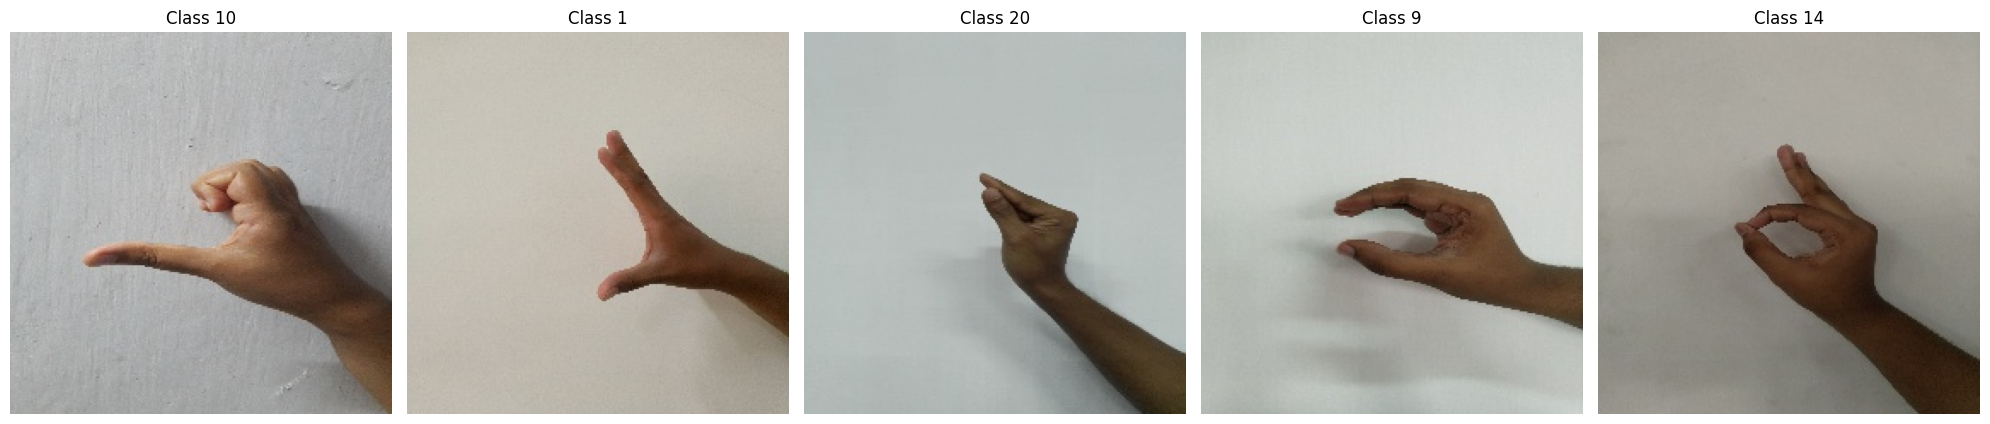

In [13]:
import random

# select 5 random classes from 0-37
randClasses = random.sample(range(38), 5)

# plot 5 random images from each class
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs = axs.ravel()

#plotting the images of the random classes
for i, classIndex in enumerate(randClasses):
    className = class_names[classIndex]
    imageFromFile = os.listdir(train_data_path+'/'+className)
    random_image = random.choice(imageFromFile)
    imagePath = train_data_path + '/' + className + '/' + random_image
    img = plt.imread(imagePath)
    axs[i].imshow(img)
    axs[i].set_title(f"Sign Number {className}")

plt.show()


Exploring the training dataset

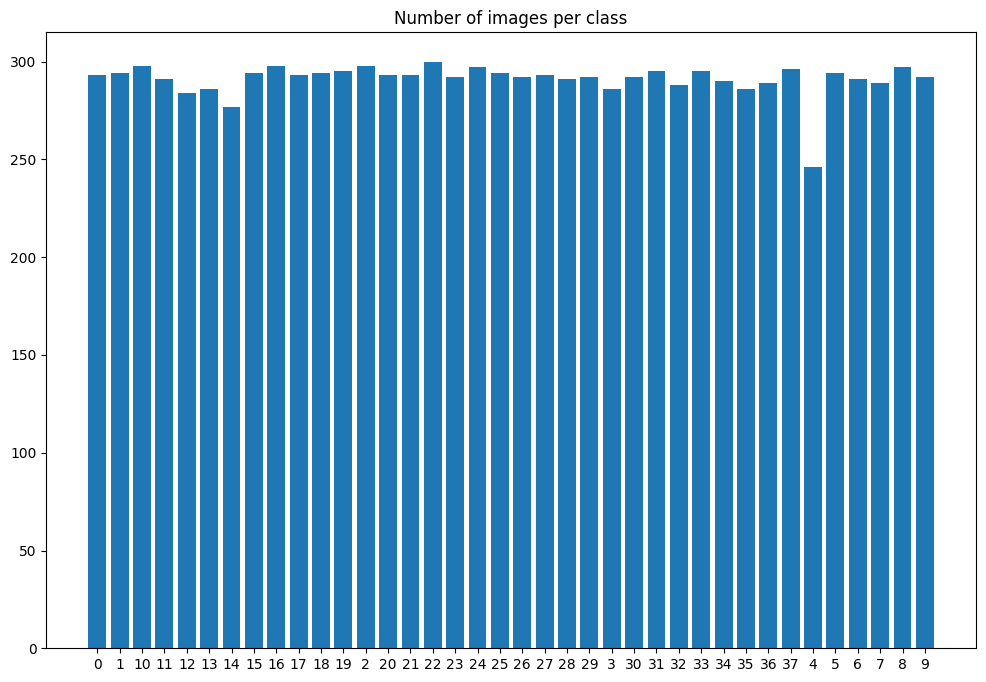

In [14]:
# check the number of images in each class in the training set
# and plot a bar chart to visualize the distribution and check for class imbalance
counter = []
for i in range(num_classes):
    count = len(os.listdir(train_data_path+'/'+class_names[i]))
    counter.append(count)
    
plt.figure(figsize=(12, 8))
plt.bar(class_names, counter)
plt.title("Number of images per class")

plt.show()



The above figure shows that the training set has a balanced amount of image in each class

In [17]:
for image_batch, label_batch in trainGenerated:
    print("Shape of Image Batch: ", image_batch.shape)
    print("Shape of Label Batch: ", label_batch.shape)
    break


Shape of Image Batch:  (32, 180, 180, 3)
Shape of Label Batch:  (32, 38)


## Model Architecture

- Conv2D: This layer applies a specfied number of convolution fiters to the input image, with each filter learning a specific feature from the image.
- MaxPooling2D: This layer reduces the spatial dimensions of the feature maps generated by the Conv2D layer, by only retaining the maximum value within each poling window.
- BatchNormalization: This layer normalizes the input of the previous layer by subtacting the batch mean and dividing by the batch standard deviation, which helps to stablize the learning process and improve model performance.

- Dropout: This layer randomly drops out a specified percentaege of the input units during training, which helps to prevent over-fitting by forcing the network to learn more robust features.

- Flatten: This layer flattens the output of the previous layer into a 1-dimensonal vector, which can be fed into a fully connected layer.

- Dense: This layer is a fully connected layer, where each neuron in the layer is connected to every neuron in the prevous layer. The number of neurons in the layer is determned by the `units` parameter, and the activation function is specified by the `activation` parameter. The last dense layer uses the `softmax` actvation function, which normalizes the output to a probability distribution over the output classes.

In [18]:
# Define the model
model = Sequential([
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu',
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

### Compile the Model


- The Adam optimizer is a popular stochastic gradient descent optimizer that can adaptively adjust learning rates during training
- Categorical crossentropy is commonly used in multi-class classification problems. 
- Accuracy metric measures the percentage of correct predictions made by the model.

It is crucial to note that the optimizer, loss function, and metrics used may differ based on the job and dataset. It is suggested that appropriate solutions be chosen depending on the individual needs and features of the picture categorization challenge.

In [19]:
# compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [20]:
# summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 89, 89, 16)       64        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 89, 89, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0

#### Model Checkpoint

Implementing checkpoints to save the weights of the model through each epoch to save the progress of the model. This is done to avoid retraining the model from scratch in case of any interruption.


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create a directory to store the checkpoints
if not os.path.exists('./checkpointWeights'):
    os.makedirs('./checkpointWeights')

epochs = 10 # Set low epochs for testing purposes
checkpoints_savePath = "./checkpointWeights/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoints_savePath, 
                                      monitor='val_accuracy', save_best_only=False, mode='max')
history = None

# Set initial epoch to 0
initialEpoch = 0

# Check if there are any checkpoints in the checkpoints directory
if len(os.listdir('./checkpointWeights')) > 0:
    # Find the latest checkpoint file and extract the epoch number from the file name
    latestEpoch = max([int(f.split('-')[0].split('.')[1]) for f in os.listdir('./checkpointWeights')])
    latestCheckpoint = [f for f in os.listdir('./checkpointWeights') if f.startswith(f'weights.{latestEpoch:02d}-')][-1]

    # get the validation accuracy from the latest checkpoint file
    val_accuracy = float(latestCheckpoint.split('-')[1].split('.')[0])

    # Load the weights from the latest checkpoint file
    model.load_weights(f'./checkpointWeights/{latestCheckpoint}')

    # update initial Epoch
    initialEpoch = latestEpoch
    
# fit the model and train with checkpoint callback
history = model.fit(trainGenerated, 
                    epochs=epochs, 
                    validation_data=valGenerated,
                    initialEpoch=initialEpoch,
                    callbacks=[checkpoint_callback])

# save the model after training is complete
model.save('cnn_model.h5')

Epoch 1/10
276/276 [==============================] - 362s 1s/step - loss: 3.1654 - accuracy: 0.1874 - val_loss: 3.4179 - val_accuracy: 0.0887
Epoch 2/10
276/276 [==============================] - 304s 1s/step - loss: 1.8190 - accuracy: 0.4706 - val_loss: 1.7853 - val_accuracy: 0.4697
Epoch 3/10
276/276 [==============================] - 480s 2s/step - loss: 1.1223 - accuracy: 0.6521 - val_loss: 1.4769 - val_accuracy: 0.5496
Epoch 4/10
276/276 [==============================] - 543s 2s/step - loss: 0.7947 - accuracy: 0.7420 - val_loss: 1.5927 - val_accuracy: 0.5672
Epoch 5/10
276/276 [==============================] - 444s 2s/step - loss: 0.5539 - accuracy: 0.8232 - val_loss: 1.1946 - val_accuracy: 0.6874
Epoch 6/10
276/276 [==============================] - 444s 2s/step - loss: 0.4173 - accuracy: 0.8639 - val_loss: 1.2494 - val_accuracy: 0.6787
Epoch 7/10
276/276 [==============================] - 432s 2s/step - loss: 0.3445 - accuracy: 0.8892 - val_loss: 1.1925 - val_accuracy: 0.7120

### Evaluation of the Model

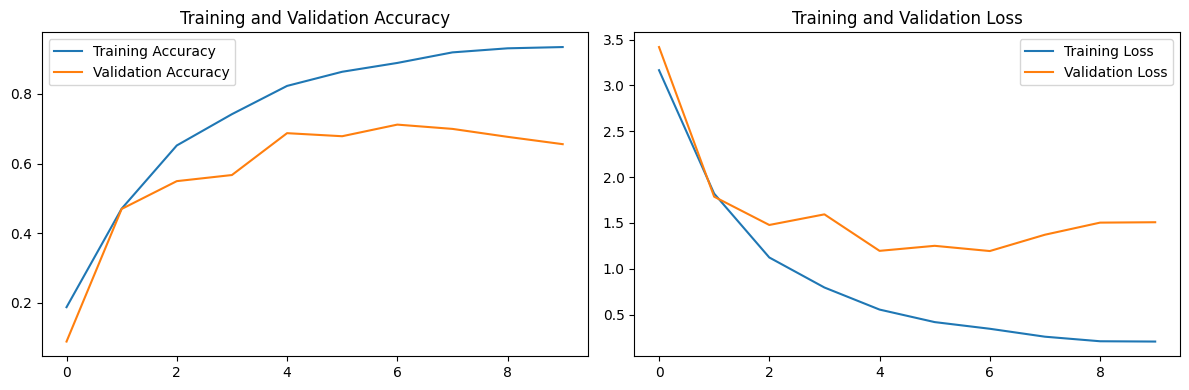

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(history.history['accuracy'], label='Training Accuracy')

axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')

axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Training and Validation Loss')


plt.show()



The plot shows the training and validation accuracy and loss over 10 epochs. The model's accuracy improves with more epochs, achieving a training accuracy of around 93.49% and a validation accuracy of approximately 65.58%. The model's loss decreases with more epochs, reaching a training loss of around 0.20 and a validation loss of approximately 1.5. The model is overfitting as the training accuracy is much higher than the validation accuracy and the training loss is much lower than the validation loss.

In [24]:
# evaluating the model on the test set
test_loss, test_acc = model.evaluate(testGenerated, verbose=2)
print(f'Accuracy of test set: {test_acc*100}')
print("Loss of test set: ", test_loss)

35/35 - 8s - loss: 1.3030 - accuracy: 0.6924 - 8s/epoch - 216ms/step
Accuracy of test set: 69.23783421516418
Loss of test set:  1.3029981851577759


The accuracy of test set is much lower than that of the training set and the loss is also higher. This is because the model is overfitting on the training set and is unable to generalize well on the test set.

## Transfer Learning

Using the VGG16 model for transfer learning. VGG16 is a convolutional neural network with 16 layers, which is pre-trained on over one million images from the ImageNet database. We can use the pre-trained weights from this model by setting the weights argument to "imagenet" when implementing the VGG16 model.

In [25]:
# importing libraries for transfer learning model

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [26]:
baseModel = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# freeze all the layers in the base model
for layer in baseModel.layers:
    layer.trainable = False


In [28]:
model_X = baseModel.output
model_X = GlobalAveragePooling2D()(model_X)
model_X = Dense(256, activation='relu')(model_X)

predictions = Dense(num_classes, activation='softmax')(model_X)


In [29]:
# Define the model to train with the VGG16 model as the base model
tl_Model = Model(inputs=baseModel.input, outputs=predictions)


In [30]:
# compile the pretrained model
tl_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Fitting the model with 5 epochs

In [36]:
tl_Model.fit(trainGenerated, epochs=5, validation_data=valGenerated)


Epoch 1/5
276/276 [==============================] - 890s 3s/step - loss: 1.6486 - accuracy: 0.5538 - val_loss: 1.1049 - val_accuracy: 0.6690
Epoch 2/5
276/276 [==============================] - 855s 3s/step - loss: 0.6997 - accuracy: 0.7814 - val_loss: 0.9031 - val_accuracy: 0.7349
Epoch 3/5
276/276 [==============================] - 837s 3s/step - loss: 0.4588 - accuracy: 0.8521 - val_loss: 0.9364 - val_accuracy: 0.7366
Epoch 4/5
276/276 [==============================] - 817s 3s/step - loss: 0.3151 - accuracy: 0.9007 - val_loss: 0.8803 - val_accuracy: 0.7489
Epoch 5/5
276/276 [==============================] - 985s 4s/step - loss: 0.2239 - accuracy: 0.9277 - val_loss: 0.9445 - val_accuracy: 0.7594


In [73]:
# evaluate the model on the test set
transfer_learning_loss, transfer_learning_accuracy = tl_Model.evaluate(testGenerated, verbose=2)

70/70 - 193s - loss: 0.8718 - accuracy: 0.7742 - 193s/epoch - 3s/step


### Comparing the results of the model with and without transfer learning

In [33]:
#compare the results of transfer learning and the model without transfer learning
print("Test Accuracy of scratch CNN model: ", test_acc)
print("Test Loss of scratch CNN model: ", test_loss)
print("Test Accuracy of model using transfer learning: ", transfer_learning_accuracy)
print("Test Loss of model using transfer learning: ", transfer_learning_loss)

Test Accuracy of scratch CNN model:  69.23783421516418
Test Loss of scratch CNN model:  1.3029981851577759
Test Accuracy of model using transfer learning:  0.7742369771003723
Test Loss of model using transfer learning:  0.8718146681785583


From the above accuracy and loss comparison between the model with and without transfer learning, we can see that the model with transfer learning performs better than the model without transfer learning. The model with transfer learning has higher test accuracy and lower loss than the model without transfer learning.

### Evaluating predicted and actual labels for the test set images

#### Scratch Model

1/1 [==============================] - 0s 130ms/step


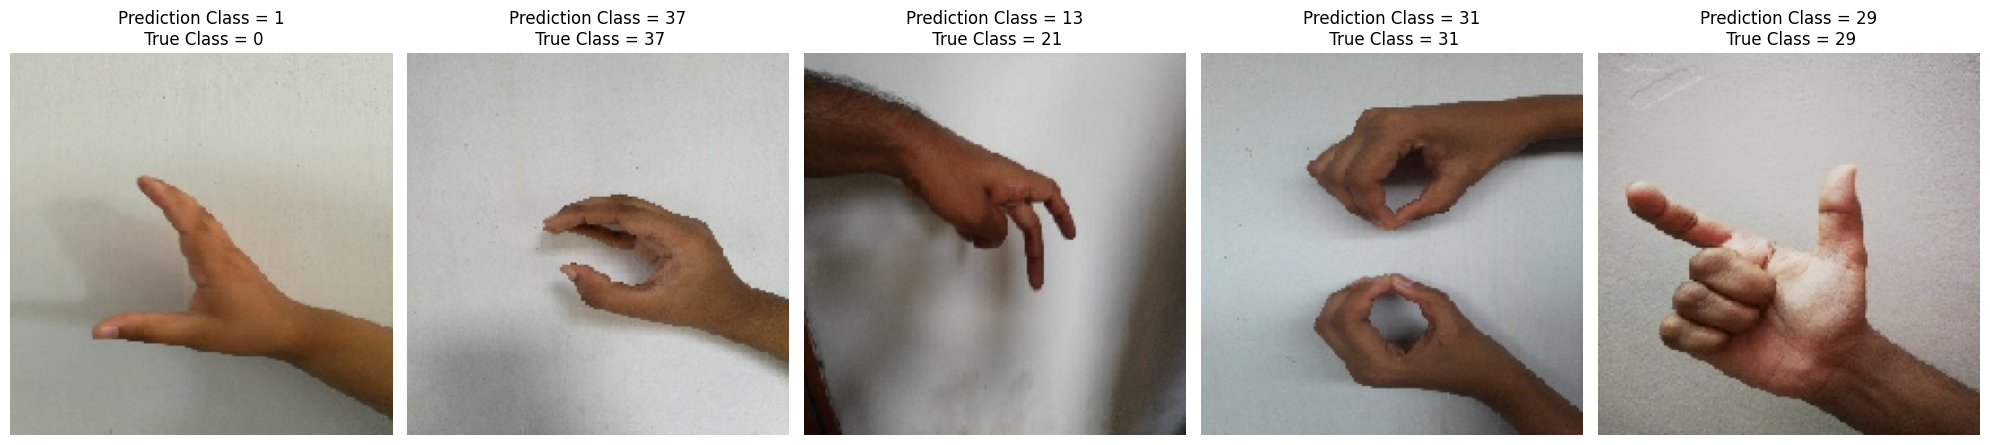

In [71]:
sampleImages, sampleLabels = next(testGenerated)

# predict using the model without transfer learning
pred_Class = model.predict(sampleImages)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the images and the predicted and true labels
for i in range(5):
    img = sampleImages[i].astype(np.uint8)
    axs[i].imshow(img)
    axs[i].set_title(f"Prediction Class = {np.argmax(pred_Class[i])}\n True Class = {np.argmax(sampleLabels[i])}")

plt.show()



The scratch model has predicted four images correctly and one image incorrectly. 

#### Transfer Learning Model

1/1 [==============================] - 3s 3s/step


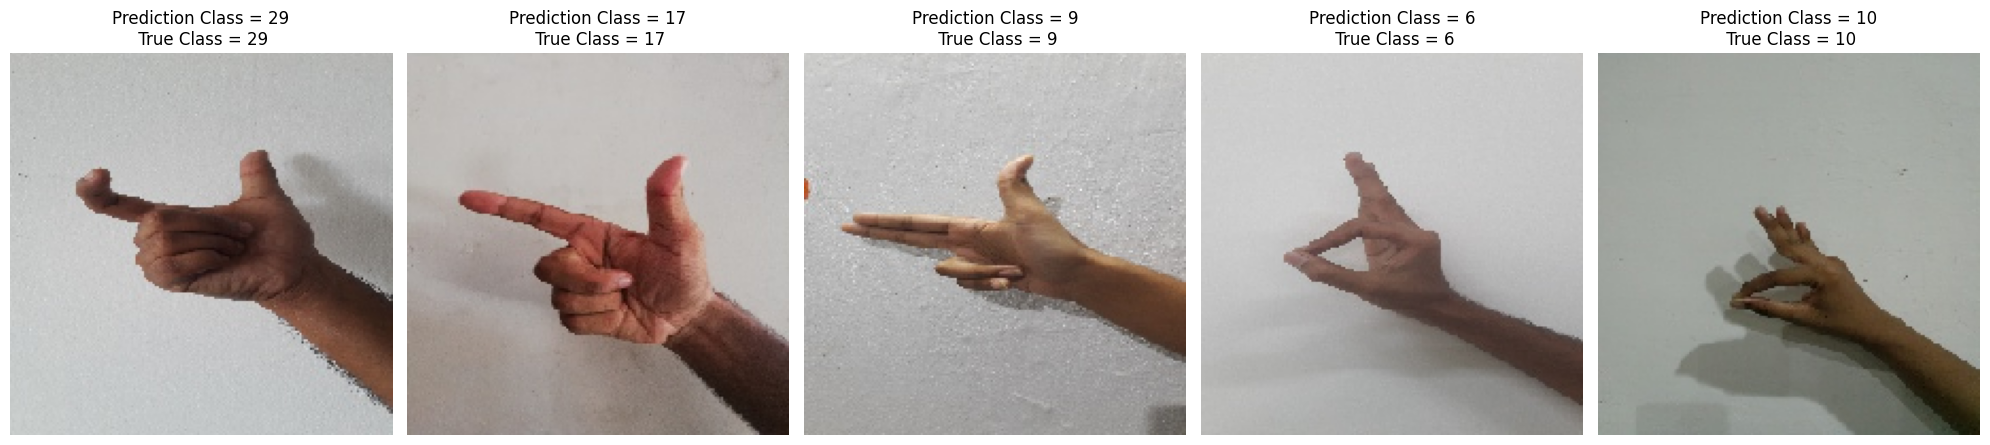

In [70]:
# Sample results using tranfer learning
sampleImages, sampleLabels = next(testGenerated)

pred_Class = tl_Model.predict(sampleImages)

fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    img = sampleImages[i].astype(np.uint8)
    axs[i].imshow(img)
    axs[i].set_title(f"Prediction Class = {np.argmax(pred_Class[i])}\n True Class = {np.argmax(sampleLabels[i])}")


plt.show()



The transfer learning model has predicted all the images correctly.

## Predicting the label for test case data

In [34]:
# path to the unlabeled images
test_case_path = './Dataset/Sign Language Detection/Test'


In [41]:
# libraries for image preprocessing
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

In [42]:
testCaseFiles = os.listdir(test_case_path)
print("Number of test images present: ", len(testCaseFiles))

Number of test images present:  3


Using the transfer learning model to predict the label for the test case data

1/1 [==============================] - 0s 440ms/step
The predicted class for image 20180625_203333.jpg is 29


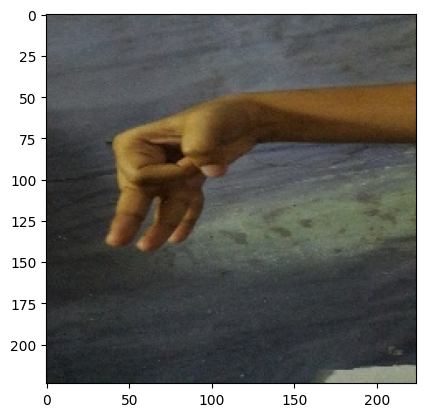

1/1 [==============================] - 1s 585ms/step
The predicted class for image 20180625_230047.jpg is 23


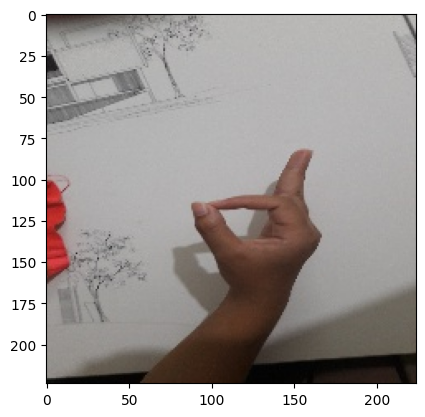

1/1 [==============================] - 0s 418ms/step
The predicted class for image 20180701_194331.jpg is 26


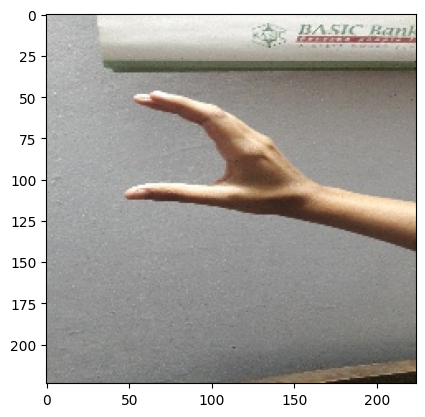

In [45]:
for file in testCaseFiles:
    imagePath = os.path.join(test_case_path, file)
   
    # Load the image and resize to (224, 224)
    x_img = image.load_img(imagePath, target_size=(224, 224))
    x = image.img_to_array(x_img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) # preprocess the images

    # Predict the class of the image
    pred_Y = tl_Model.predict(x)
    predictedLabels = np.argmax(pred_Y, axis=1)[0] # get the index of the predicted class
    predictedClass = class_names[predictedLabels]
    print("The predicted class for image {} is {}".format(file, predictedClass))
    
    # display the image
    plt.imshow(x_img)
    plt.show()

    


The model has predicted the label for the image with label 29 correctly. But has misclassified the image with label 23 as label 26.

## Result and Conclusion

In this report, we have created a CNN model to classify the sign language digits. The model has achieved a training accuracy of `93.49%` and a test accuracy of `69.23%`. The model with transfer learning has achieved a training accuracy of `92.77%` and a test accuracy of `77.42%`. The model with transfer learning got a higher accuracy than the model without transfer learning. The model with transfer learning predicted all the images in the test set correctly. The model without transfer learning predicted four images correctly and one image incorrectly. The model with transfer learning predicted the label for the test case  image with label 29 correctly but misclassified the image with label 23 as label 26. 
<br>
The model can be improved by increasing the number of epochs and by using different optimizers and loss functions. The model can also be improved by using different architectures and by tuning the hyperparameters. The number of images in each class can be increased to improve the model. The model can also be improved by using data augmentation techniques.